/tmp/ipykernel_1365990/3231030092.py:9: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv(file_path)


Total correct mappings: 9396
Total ship MDM counts: 9737
Average Mapping Accuracy: 96.50%


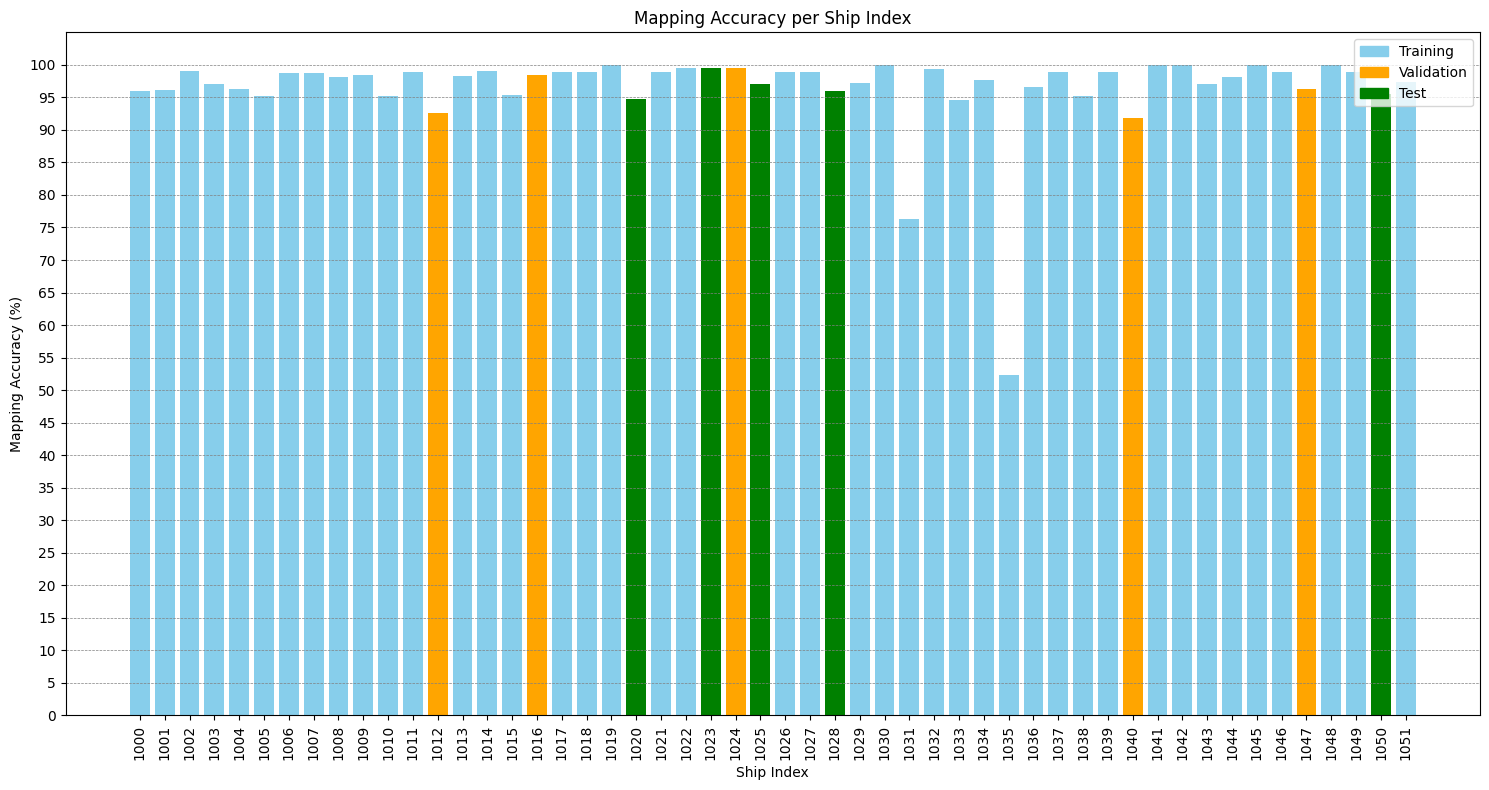

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import json
import pandas as pd

# Load the data
file_path = 'train_t5-base_td_unit_80/checkpoint-4880/test_with_predictions.csv'
df_test = pd.read_csv(file_path)

# Load the ships_idx_selection.json file
with open('../translation/ship_idx_selection.json', 'r') as json_file:
    ship_idx_selection = json.load(json_file)

train_idx = set(ship_idx_selection["training_ship_idx_selection"])
val_idx = set(ship_idx_selection["validation_ship_idx_selection"])
test_idx = set(ship_idx_selection["test_ship_idx_selection"])

# Count the number of rows for each ships_idx
ship_rows_counts = df_test.groupby('ships_idx').size()

# Filter the DataFrame where 'MDM' is "TRUE" (as a string) and then count the rows for each ships_idx
ship_mdm_counts = df_test[df_test['MDM']].groupby('ships_idx').size()

correct_mappings = df_test[
    (df_test['p_correct'] == True)
].groupby('ships_idx').size()

# Combine the three Series into a DataFrame with appropriate column names
result = pd.concat([ship_rows_counts, ship_mdm_counts, correct_mappings], axis=1)
result.columns = ['ship_rows_counts', 'ship_mdm_counts', 'correct_mappings']

# Reset index to turn the index into a regular column if necessary
result = result.reset_index()

# Fill NaN values with 0 where there are no mappings or mdm counts
result['ship_mdm_counts'] = result['ship_mdm_counts'].fillna(0)
result['correct_mappings'] = result['correct_mappings'].fillna(0)

# Calculate mapping accuracy and handle division by zero by replacing infinity with NaN or zero
result['mapping_accuracy'] = result['correct_mappings'] / result['ship_mdm_counts'].replace({0: pd.NA})

# Replace infinite values with NaN if there were division by zero cases
result['mapping_accuracy'] = result['mapping_accuracy'].fillna(0)

# Convert to percentage if desired
result['mapping_accuracy'] *= 100

# Calculate the average mapping accuracy
total_correct_mappings = result['correct_mappings'].sum()
total_ship_mdm_counts = result['ship_mdm_counts'].sum()
average_mapping_accuracy = (total_correct_mappings / total_ship_mdm_counts) * 100 if total_ship_mdm_counts != 0 else 0

# Print the total counts and average mapping accuracy
print(f"Total correct mappings: {total_correct_mappings}")
print(f"Total ship MDM counts: {total_ship_mdm_counts}")
print(f"Average Mapping Accuracy: {average_mapping_accuracy:.2f}%")

# Plotting
plt.figure(figsize=(15, 8))  # Adjust the size as needed

# Colors for each dataset
colors = {
    'training': 'skyblue',
    'validation': 'orange',
    'test': 'green'
}

# Plot training, validation, and test sets with different colors
for idx in result['ships_idx']:
    if idx in train_idx:
        color = colors['training']
    elif idx in val_idx:
        color = colors['validation']
    elif idx in test_idx:
        color = colors['test']
    else:
        color = 'grey'  # default color if not found in any set

    plt.bar(idx, result[result['ships_idx'] == idx]['mapping_accuracy'].values[0], color=color)

# Add legend to differentiate datasets
handles = [plt.Rectangle((0,0),1,1, color=colors['training']), 
           plt.Rectangle((0,0),1,1, color=colors['validation']),
           plt.Rectangle((0,0),1,1, color=colors['test'])]
labels = ['Training', 'Validation', 'Test']
plt.legend(handles, labels)

plt.title('Mapping Accuracy per Ship Index')
plt.xlabel('Ship Index')
plt.ylabel('Mapping Accuracy (%)')

# Set y-axis ticks to increment by 5
plt.yticks(range(0, 101, 5))  # Assuming the accuracy percentage ranges from 0 to 100

# Add horizontal grid lines for better readability, only horizontal by setting axis='y'
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, color='grey')

# Rotate x-axis labels to prevent overlap
plt.xticks(result['ships_idx'], rotation=90)

plt.tight_layout()  # Adjust layout to make sure everything fits without overlap
plt.show()



In [2]:
false_count = (df_test['p_MDM']).sum()
print(f"Total number of rows where p_MDM is FALSE: {false_count}")

# Crosstab to show the combinations of p_MDM and MDM
mdm_crosstab = pd.crosstab(df_test['p_MDM'], df_test['MDM'])
print(mdm_crosstab)

# This prints a table like:
# MDM       FALSE  TRUE
# p_MDM
# FALSE     x      y
# TRUE      z      w
# z(duplicated

Total number of rows where p_MDM is FALSE: 34506
MDM    False  True 
p_MDM              
False  27529     29
True   24798   9708
